In [1]:
pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from gurobipy import *


In [3]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install numpy

In [5]:
pip install xlwt

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd

In [11]:
file_path = r"C:/Users/Charles/OneDrive/KULEUVEN/Master 2/Operations Strategy in Manufacturing and Services/Obligatory Assignment\DEA Data.xlsx"

# Load the data from the "Raw Data" sheet
data = pd.read_excel(file_path, sheet_name="Short_Raw data_finalversion")


In [12]:
print(data.head())

    Country  Annual nitrous oxide emissions  Concentrations of PM2.5  \
0   Albania                       41.796132                 18.98271   
1   Belarus                      138.604750                 16.49174   
2   Belgium                      303.821657                 13.27885   
3  Bulgaria                       34.667333                 20.41206   
4    Canada                        4.244909                  7.15364   

   Annual greenhouse gas emissions in CO2  Manufacturing      AHDI  \
0                              337.120461           5.67  0.494294   
1                              537.636809          20.64  0.381433   
2                             4124.059893          12.69  0.712226   
3                              535.515469          13.63  0.544336   
4                               85.897102           9.98  0.780910   

   GDP per capita  
0       10192.529  
1       18122.863  
2       39160.324  
3       16186.409  
4       43761.527  


In [13]:
print(data.columns)  # Print all column names


Index(['Country', 'Annual nitrous oxide emissions', 'Concentrations of PM2.5',
       'Annual greenhouse gas emissions in CO2', 'Manufacturing', 'AHDI',
       'GDP per capita'],
      dtype='object')


In [14]:
DMUs = data['Country']  # Decision-Making Units
inputs = data[['Annual nitrous oxide emissions', 'Concentrations of PM2.5', 'Annual greenhouse gas emissions in CO2']].values
outputs = data[['Manufacturing','AHDI', 'GDP per capita']].values

# Print the extracted data to verify
print("=== Decision-Making Units (DMUs) ===")
print(DMUs)
print("\n=== Inputs ===")
print(inputs)
print("\n=== Outputs ===")
print(outputs)

armenia_data = data[data['Country'] == 'Armenia']

# Print the extracted data for Armenia
print("=== Information for Armenia ===")
print(armenia_data)



=== Decision-Making Units (DMUs) ===
0            Albania
1            Belarus
2            Belgium
3           Bulgaria
4             Canada
5             Cyprus
6            Czechia
7            Finland
8             France
9             Greece
10           Georgia
11           Iceland
12            Israel
13             Italy
14        Kazakhstan
15         Lithuania
16             Malta
17       Netherlands
18          Portugal
19            Serbia
20          Slovakia
21             Spain
22    United Kingdom
23     United States
24        Uzbekistan
Name: Country, dtype: object

=== Inputs ===
[[4.17961319e+01 1.89827100e+01 3.37120461e+02]
 [1.38604750e+02 1.64917400e+01 5.37636809e+02]
 [3.03821657e+02 1.32788500e+01 4.12405989e+03]
 [3.46673334e+01 2.04120600e+01 5.35515469e+02]
 [4.24490936e+00 7.15364000e+00 8.58971017e+01]
 [3.69926076e+01 1.51268600e+01 8.26379676e+02]
 [8.16649951e+01 1.75159000e+01 1.51941090e+03]
 [2.17122218e+01 5.82623000e+00 2.60718604e+02]
 [7.15858

In [15]:
# Number of DMUs, inputs, and outputs
num_DMUs = len(DMUs)
num_inputs = inputs.shape[1]
num_outputs = outputs.shape[1]


In [16]:
# Create a list to store efficiency scores
efficiency_scores = []
input_slacks = []
output_slacks = []
lambda_values = []

In [17]:
# Loop through each DMU to calculate its efficiency and slacks
for i in range(num_DMUs):
    # Create the Gurobi model
    model = Model("DEA_BCC_Input_Oriented")
    model.setParam('OutputFlag', 0)  # Suppress Gurobi output for a cleaner log

    # Create variables: lambdas for DMUs and theta (efficiency score)
    lambdas = model.addVars(num_DMUs, lb=0, vtype=GRB.CONTINUOUS, name="lambdas")
    theta = model.addVar(lb=0, ub=1, vtype=GRB.CONTINUOUS, name="theta")

    # Create slack variables for inputs and outputs
    input_slack_vars = model.addVars(num_inputs, lb=0, vtype=GRB.CONTINUOUS, name="input_slack")
    output_slack_vars = model.addVars(num_outputs, lb=0, vtype=GRB.CONTINUOUS, name="output_slack")

    # Set objective: minimize theta
    model.setObjective(theta, GRB.MINIMIZE)

    # Add input constraints with input slack
    for j in range(num_inputs):
        model.addConstr(
            sum(lambdas[k] * inputs[k, j] for k in range(num_DMUs)) + input_slack_vars[j] == theta * inputs[i, j],
            name=f"input_constraint_{j}"
        )

    # Add output constraints with output slack
    for r in range(num_outputs):
        model.addConstr(
            sum(lambdas[k] * outputs[k, r] for k in range(num_DMUs)) - output_slack_vars[r] == outputs[i, r],
            name=f"output_constraint_{r}"
        )

    # Add convexity constraint (BCC assumption)
    model.addConstr(sum(lambdas[k] for k in range(num_DMUs)) == 1, name="convexity_constraint")

    # Solve the model
    model.optimize()

    # Get the efficiency score for the current DMU
    if model.status == GRB.OPTIMAL:
        efficiency_scores.append(model.getVarByName("theta").X)
        
        # Extract slack values
        input_slacks.append([input_slack_vars[j].X for j in range(num_inputs)])
        output_slacks.append([output_slack_vars[r].X for r in range(num_outputs)])
        # Extract weights (\(\lambda_j\)) for this DMU
        lambda_values.append([lambdas[k].X for k in range(num_DMUs)])
    else:
        efficiency_scores.append(None)
        input_slacks.append([None] * num_inputs)
        output_slacks.append([None] * num_outputs)
        lambda_values.append([None] * num_DMUs)


Restricted license - for non-production use only - expires 2026-11-23


In [19]:
# Add efficiency scores and slacks to the DataFrame
data['Efficiency'] = efficiency_scores
for j in range(num_inputs):
    data[f'Input Slack {j+1}'] = [slack[j] for slack in input_slacks]
for r in range(num_outputs):
    data[f'Output Slack {r+1}'] = [slack[r] for slack in output_slacks]

# Create a DataFrame for lambda (weights) results
lambda_df = pd.DataFrame(lambda_values, columns=[f'Lambda for DMU {k+1}' for k in range(num_DMUs)])
lambda_df.insert(0, 'Country', DMUs)

# Save the results to new Excel sheets
output_file = r"C:\Users\Charles\OneDrive\KULEUVEN\Master 2\Operations Strategy in Manufacturing and Services\DEA_Results_with_Slacks_and_Weights.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    data.to_excel(writer, sheet_name="Efficiency and Slacks", index=False)
    lambda_df.to_excel(writer, sheet_name="Lambda Weights", index=False)

print(f"DEA analysis completed. Results saved to '{output_file}' with slacks and weights included.")

DEA analysis completed. Results saved to 'C:\Users\Charles\OneDrive\KULEUVEN\Master 2\Operations Strategy in Manufacturing and Services\DEA_Results_with_Slacks_and_Weights.xlsx' with slacks and weights included.


In [21]:
import matplotlib.pyplot as plt


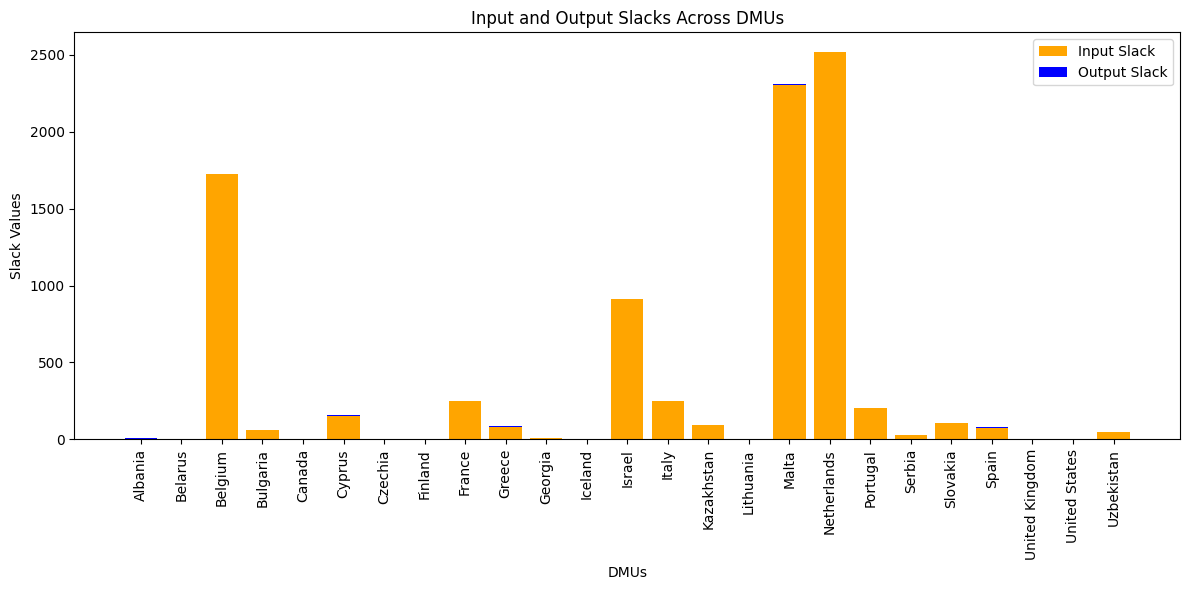

In [22]:
# Aggregate input and output slacks
input_slacks = data[['Input Slack 1', 'Input Slack 2', 'Input Slack 3']].sum(axis=1)
output_slacks = data[['Output Slack 1', 'Output Slack 2']].sum(axis=1)

# Plot stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(data['Country'], input_slacks, label='Input Slack', color='orange')
plt.bar(data['Country'], output_slacks, bottom=input_slacks, label='Output Slack', color='blue')
plt.xticks(rotation=90)
plt.xlabel('DMUs')
plt.ylabel('Slack Values')
plt.title('Input and Output Slacks Across DMUs')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\Charles\AppData\Local\Temp\ipykernel_8424\3074011246.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis', len(normalized_ratios))  # Vibrant color palette


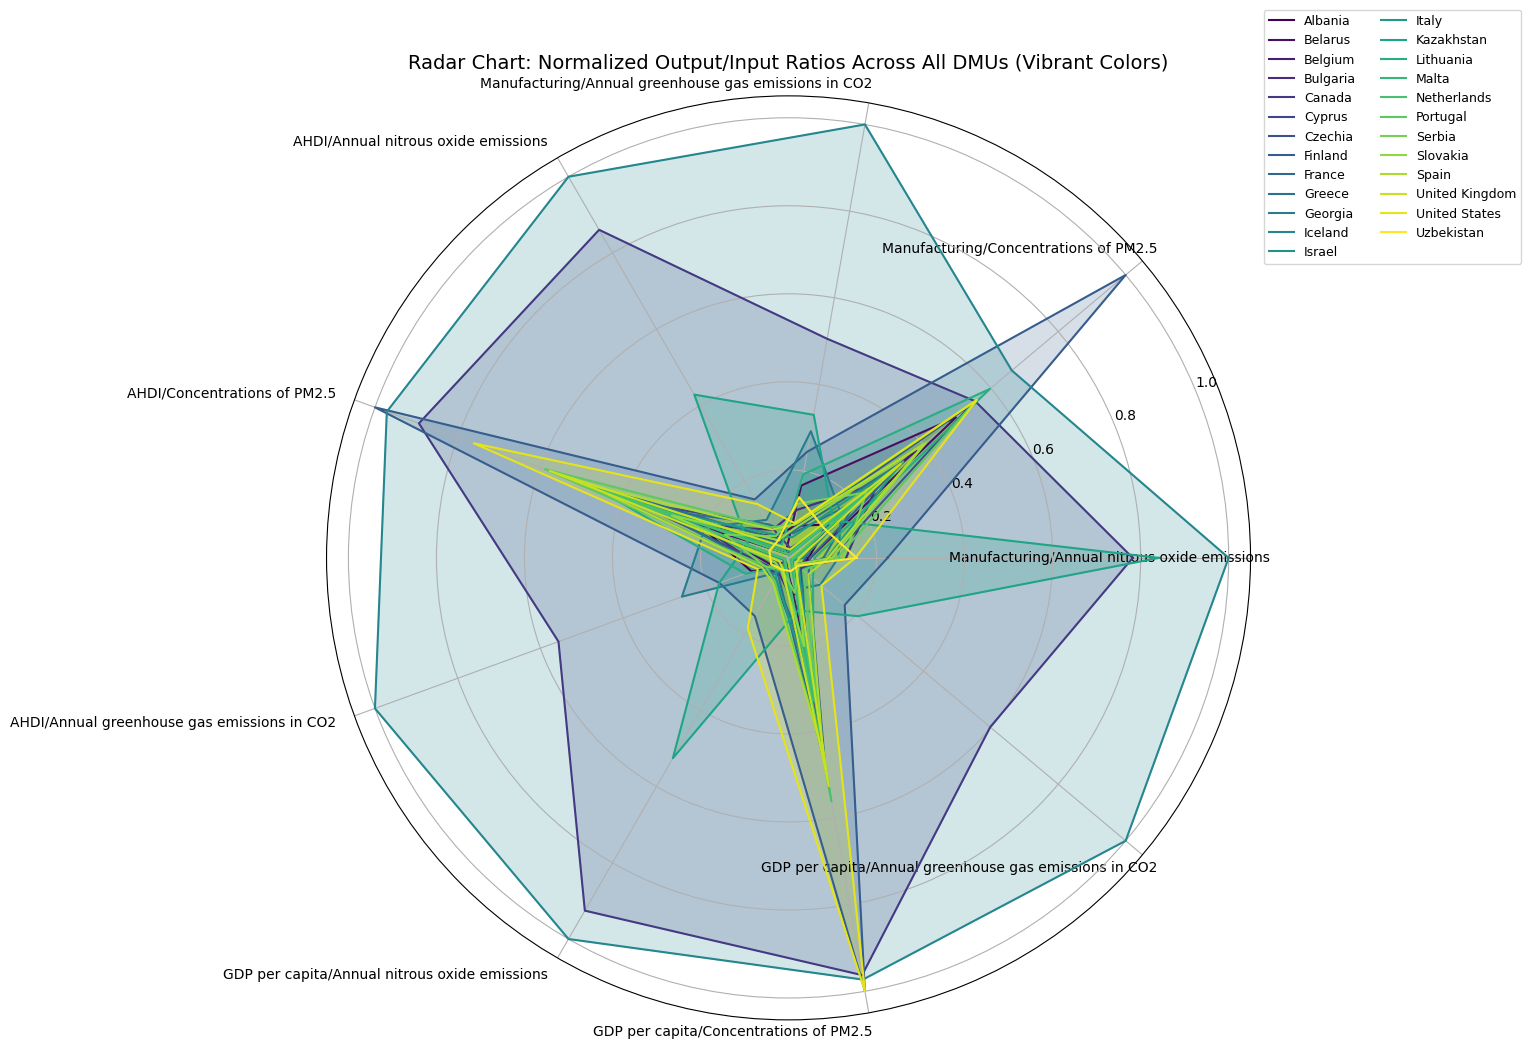

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import matplotlib.cm as cm

# Column names for inputs and outputs
input_columns = ['Annual nitrous oxide emissions', 'Concentrations of PM2.5', 'Annual greenhouse gas emissions in CO2']
output_columns = ['Manufacturing', 'AHDI', 'GDP per capita']

# Step 1: Calculate Output/Input ratio for each pair of output and input
output_input_ratios = pd.DataFrame(index=data.index)
for output in output_columns:
    for input_col in input_columns:
        ratio_col = f'{output}/{input_col}'
        output_input_ratios[ratio_col] = data[output] / data[input_col]

# Step 2: Normalize Output/Input ratio for each pair
normalized_ratios = output_input_ratios.divide(output_input_ratios.max(axis=0), axis=1)

# Add DMU names to normalized_ratios for reference
normalized_ratios['DMU'] = data['Country']

# Step 3: Prepare data for radar chart
categories = normalized_ratios.columns[:-1]  # All ratio columns
angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]  # Close the circle

# Generate vibrant colors using the 'viridis' colormap
colors = cm.get_cmap('viridis', len(normalized_ratios))  # Vibrant color palette

# Plot one radar chart for all DMUs
plt.figure(figsize=(12, 12))
ax = plt.subplot(111, polar=True)

for idx, row in normalized_ratios.iterrows():
    values = row[:-1].values.tolist()  # Exclude the 'DMU' column
    values += values[:1]  # Close the circle for radar plot
    color = colors(idx / len(normalized_ratios))  # Assign a vibrant color
    ax.plot(angles, values, linewidth=1.5, linestyle='solid', label=row['DMU'], color=color)
    ax.fill(angles, values, alpha=0.2, color=color)  # Adjust alpha for more vibrant fills

# Add category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10, rotation=30, ha='right')

# Add title and legend
plt.title('Radar Chart: Normalized Output/Input Ratios Across All DMUs (Vibrant Colors)', size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9, ncol=2)  # Adjust legend for 25 DMUs
plt.show()


In [23]:
#Summary statistics: 
print("=== Inputs Summary ===")
print(data[['Annual nitrous oxide emissions', 'Concentrations of PM2.5', 'Annual greenhouse gas emissions in CO2']].describe)
print("\n=== Outputs Summary ===")
print(data[['Manufacturing','AHDI', 'GDP per capita']].describe())


=== Inputs Summary ===
<bound method NDFrame.describe of     Annual nitrous oxide emissions  Concentrations of PM2.5  \
0                        41.796132                 18.98271   
1                       138.604750                 16.49174   
2                       303.821657                 13.27885   
3                        34.667333                 20.41206   
4                         4.244909                  7.15364   
5                        36.992608                 15.12686   
6                        81.664995                 17.51590   
7                        21.712222                  5.82623   
8                        71.585840                 12.20689   
9                        34.706988                 16.44555   
10                       26.057593                 22.56939   
11                        3.569440                  6.43001   
12                      126.484006                 21.65498   
13                       54.583677                 17.27739  

In [24]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


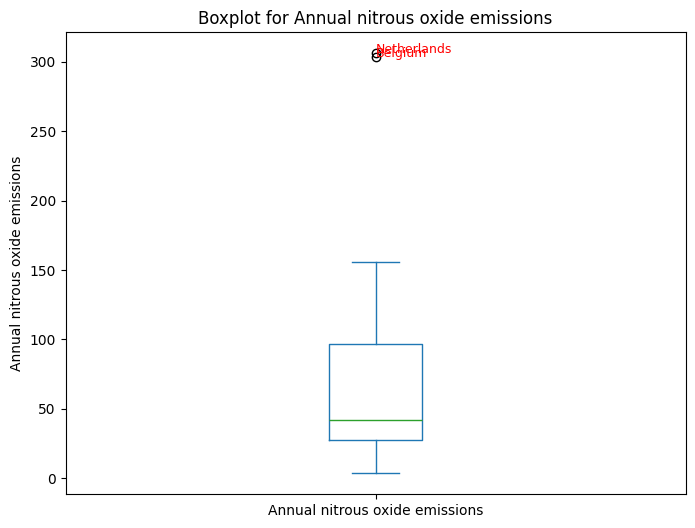

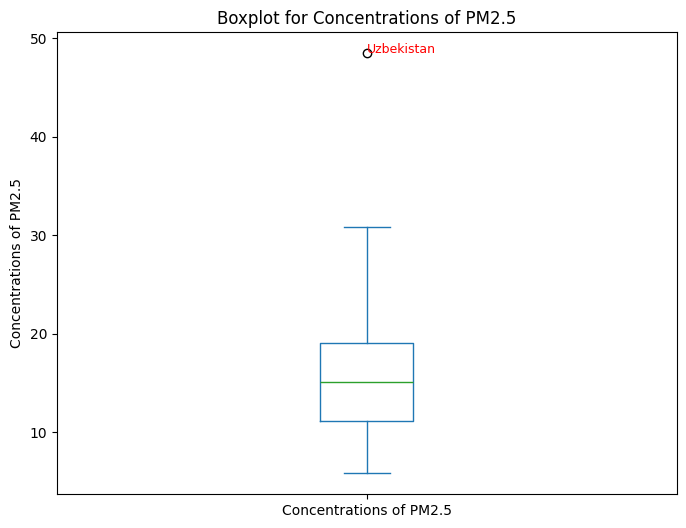

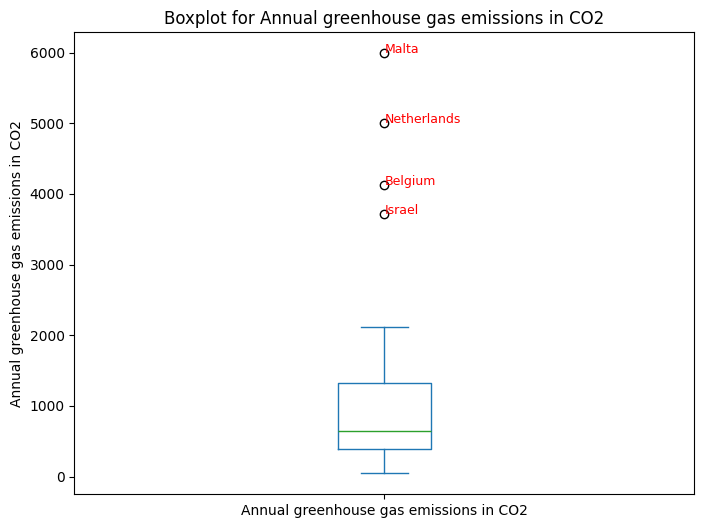

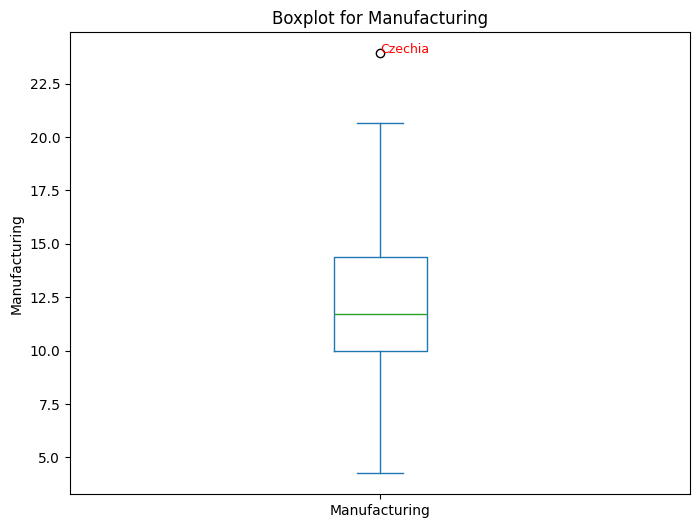

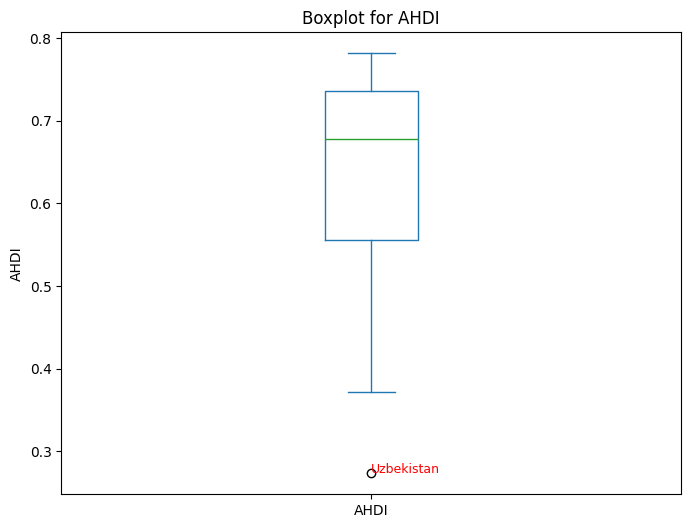

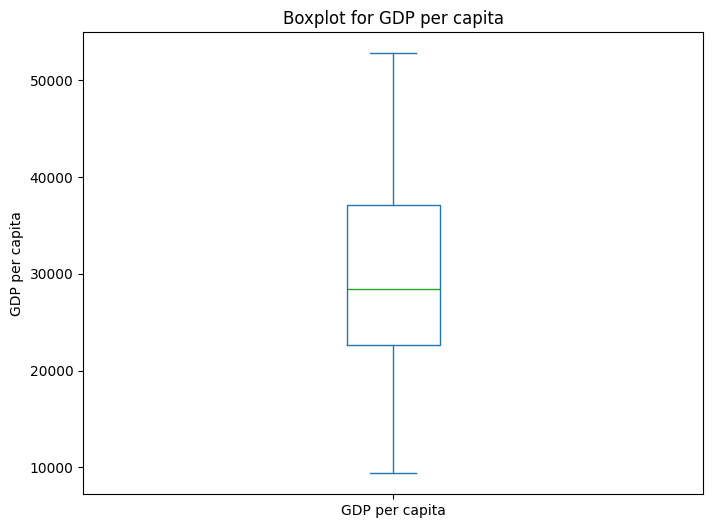

In [27]:
import matplotlib.pyplot as plt

# List of input and output columns
input_columns = ['Annual nitrous oxide emissions', 'Concentrations of PM2.5', 'Annual greenhouse gas emissions in CO2']
output_columns = ['Manufacturing', 'AHDI', 'GDP per capita']

# Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    return outliers

# Create separate boxplots for inputs
for column in input_columns:
    plt.figure(figsize=(8, 6))  # Create a new figure for each boxplot
    data[column].plot(kind='box', title=f"Boxplot for {column}")
    plt.ylabel(column)
    
    # Detect outliers
    outliers = detect_outliers_iqr(data, column)
    outlier_values = data.loc[outliers, column]
    outlier_names = data.loc[outliers, 'Country']  # Assumes 'Country' column contains DMU names
    
    # Annotate outliers on the plot
    for outlier_value, outlier_name in zip(outlier_values, outlier_names):
        plt.text(1, outlier_value, outlier_name, fontsize=9, color='red', ha='left')

    plt.show()

# Create separate boxplots for outputs
for column in output_columns:
    plt.figure(figsize=(8, 6))  # Create a new figure for each boxplot
    data[column].plot(kind='box', title=f"Boxplot for {column}")
    plt.ylabel(column)
    
    # Detect outliers
    outliers = detect_outliers_iqr(data, column)
    outlier_values = data.loc[outliers, column]
    outlier_names = data.loc[outliers, 'Country']  # Assumes 'Country' column contains DMU names
    
    # Annotate outliers on the plot
    for outlier_value, outlier_name in zip(outlier_values, outlier_names):
        plt.text(1, outlier_value, outlier_name, fontsize=9, color='red', ha='left')

    plt.show()
